# Importamos librerías

In [1]:
import tensorflow as tf
import pathlib
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import keras

In [2]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout, BatchNormalization
from tensorflow.keras.initializers import HeNormal
from keras.regularizers import l1, l2


In [3]:
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


False

# Importamos los datos

In [4]:
path = '../../../Base de datos/Campo 100 puntos'

## Datos de entrenamiento

### Datos

In [5]:
campvectrain = np.load(path + '/campvectrain.npy')

In [6]:
np.shape(campvectrain)

(7000, 2, 100, 100)

### Coeficientes

In [7]:
coefcampvectrain = np.load(path + '/coefcampvectrain.npy')

In [8]:
np.shape(coefcampvectrain)

(7000, 7)

## Datos de prueba

### Datos

In [9]:
campvectest = np.load(path + '/campvectest.npy')

In [10]:
np.shape(campvectest)

(2000, 2, 100, 100)

### Coeficientes

In [11]:
coefcampvectest = np.load(path + '/coefcampvectest.npy')

In [12]:
np.shape(coefcampvectest)

(2000, 7)

## Datos de validación

### Datos

In [13]:
campvecval = np.load(path + '/campvecval.npy')

In [14]:
np.shape(campvecval)

(1000, 2, 100, 100)

### Coeficienes

In [15]:
coefcampvecval = np.load(path + '/coefcampvecval.npy')

In [16]:
np.shape(coefcampvecval)

(1000, 7)

# Unimos coeficientes con los datos

In [17]:
train_dataset = tf.data.Dataset.from_tensor_slices((campvectrain, coefcampvectrain))
test_dataset = tf.data.Dataset.from_tensor_slices((campvectest, coefcampvectest))
val_dataset = tf.data.Dataset.from_tensor_slices((campvecval, coefcampvecval))

In [18]:
train_dataset

<TensorSliceDataset element_spec=(TensorSpec(shape=(2, 100, 100), dtype=tf.float64, name=None), TensorSpec(shape=(7,), dtype=tf.int32, name=None))>

# Mezclar y procesar por lotes los conjuntos de datos

In [19]:
BATCH_SIZE = 10
SHUFFLE_BUFFER_SIZE = 10

train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)
val_dataset = val_dataset.batch(BATCH_SIZE)

# Creación del modelo

In [20]:
def custom_activation(x):
    return 10 * tf.nn.sigmoid(x)

In [31]:

model = Sequential()
model.add(Flatten(input_shape=(2,100,100)))
model.add(BatchNormalization())
model.add(Dense(128,activation='relu',kernel_initializer=HeNormal(), kernel_regularizer=l1(0.001)))
model.add(Dropout(0.3))
model.add(Dense(64,activation = 'relu',kernel_initializer=HeNormal(), kernel_regularizer=l1(0.001)))
model.add(Dense(128,activation = 'relu',kernel_initializer=HeNormal(), kernel_regularizer=l1(0.001)))
model.add(Dense(64,activation = 'relu',kernel_initializer=HeNormal(), kernel_regularizer=l1(0.001)))
model.add(Dropout(0.3))
model.add(Dense(128,activation = 'relu',kernel_initializer=HeNormal(), kernel_regularizer=l1(0.001)))
model.add(Dense(64,activation = 'relu',kernel_initializer=HeNormal(), kernel_regularizer=l1(0.001)))

model.add(Dense(7, activation= custom_activation))

In [38]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(2,100,100)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(7, activation = custom_activation)
])


In [39]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_3 (Flatten)         (None, 20000)             0         
                                                                 
 batch_normalization_4 (Batc  (None, 20000)            80000     
 hNormalization)                                                 
                                                                 
 dense_19 (Dense)            (None, 128)               2560128   
                                                                 
 dense_20 (Dense)            (None, 64)                8256      
                                                                 
 dense_21 (Dense)            (None, 128)               8320      
                                                                 
 dense_22 (Dense)            (None, 64)                8256      
                                                      

In [40]:
keras.utils.plot_model(model,show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


# Entrenamos el modelo

In [41]:
from keras.optimizers import Adam
optimizer = Adam(learning_rate=0.001,clipvalue=100.0)

In [42]:
model.compile(optimizer=optimizer,
              loss= 'MSE',
              metrics=['accuracy'])


In [43]:
def scheduler(epoch, lr):
  if epoch < 400:
    return lr
  else:
    return -1.65e-6*epoch +  0.00166

In [44]:
val_epochs = 1000

early_stop = tf.keras.callbacks.EarlyStopping( monitor = 'val_loss', patience = 1000,verbose = 1, 
                                              restore_best_weights = True)

reduce_lr = tf.keras.callbacks.LearningRateScheduler(scheduler)
#history = model.fit(train_dataset, validation_data=val_dataset, epochs= val_epochs, callbacks=[reduce_lr, early_stop])
history = model.fit(train_dataset, validation_data=val_dataset, epochs= val_epochs, callbacks=[reduce_lr])

Epoch 1/1000
700/700 [==============================] - 6s 8ms/step - loss: 6.9361 - accuracy: 0.3590 - val_loss: 4.8750 - val_accuracy: 0.4330 - lr: 0.0010
Epoch 2/1000
700/700 [==============================] - 5s 8ms/step - loss: 5.7110 - accuracy: 0.3886 - val_loss: 4.7891 - val_accuracy: 0.4250 - lr: 0.0010
Epoch 3/1000
700/700 [==============================] - 5s 8ms/step - loss: 5.0245 - accuracy: 0.4190 - val_loss: 3.7182 - val_accuracy: 0.4900 - lr: 0.0010
Epoch 4/1000
700/700 [==============================] - 5s 8ms/step - loss: 4.0986 - accuracy: 0.5020 - val_loss: 2.8026 - val_accuracy: 0.6120 - lr: 0.0010
Epoch 5/1000
700/700 [==============================] - 5s 8ms/step - loss: 3.9469 - accuracy: 0.5171 - val_loss: 2.7562 - val_accuracy: 0.5890 - lr: 0.0010
Epoch 6/1000
700/700 [==============================] - 5s 8ms/step - loss: 3.8322 - accuracy: 0.5214 - val_loss: 2.6999 - val_accuracy: 0.6330 - lr: 0.0010
Epoch 7/1000
700/700 [==============================] - 5s

Epoch 53/1000
700/700 [==============================] - 5s 8ms/step - loss: 3.1959 - accuracy: 0.5696 - val_loss: 2.0360 - val_accuracy: 0.7200 - lr: 0.0010
Epoch 54/1000
700/700 [==============================] - 5s 8ms/step - loss: 3.1639 - accuracy: 0.5670 - val_loss: 2.0759 - val_accuracy: 0.6920 - lr: 0.0010
Epoch 55/1000
700/700 [==============================] - 5s 8ms/step - loss: 3.1483 - accuracy: 0.5763 - val_loss: 2.0484 - val_accuracy: 0.7050 - lr: 0.0010
Epoch 56/1000
700/700 [==============================] - 5s 8ms/step - loss: 3.1276 - accuracy: 0.5757 - val_loss: 1.9840 - val_accuracy: 0.7290 - lr: 0.0010
Epoch 57/1000
700/700 [==============================] - 5s 8ms/step - loss: 3.1613 - accuracy: 0.5694 - val_loss: 2.0084 - val_accuracy: 0.6760 - lr: 0.0010
Epoch 58/1000
700/700 [==============================] - 5s 8ms/step - loss: 3.1242 - accuracy: 0.5657 - val_loss: 2.0123 - val_accuracy: 0.7290 - lr: 0.0010
Epoch 59/1000
700/700 [=============================

Epoch 105/1000
700/700 [==============================] - 5s 8ms/step - loss: 3.0214 - accuracy: 0.5790 - val_loss: 1.9619 - val_accuracy: 0.7180 - lr: 0.0010
Epoch 106/1000
700/700 [==============================] - 5s 8ms/step - loss: 3.0624 - accuracy: 0.5771 - val_loss: 1.9462 - val_accuracy: 0.7170 - lr: 0.0010
Epoch 107/1000
700/700 [==============================] - 5s 8ms/step - loss: 3.0378 - accuracy: 0.5769 - val_loss: 1.9336 - val_accuracy: 0.6900 - lr: 0.0010
Epoch 108/1000
700/700 [==============================] - 5s 8ms/step - loss: 3.0711 - accuracy: 0.5800 - val_loss: 1.9546 - val_accuracy: 0.6890 - lr: 0.0010
Epoch 109/1000
700/700 [==============================] - 5s 8ms/step - loss: 3.0679 - accuracy: 0.5730 - val_loss: 1.9442 - val_accuracy: 0.7280 - lr: 0.0010
Epoch 110/1000
700/700 [==============================] - 5s 8ms/step - loss: 3.0548 - accuracy: 0.5831 - val_loss: 1.9211 - val_accuracy: 0.7200 - lr: 0.0010
Epoch 111/1000
700/700 [======================

700/700 [==============================] - 5s 8ms/step - loss: 2.9799 - accuracy: 0.5873 - val_loss: 1.9351 - val_accuracy: 0.7180 - lr: 0.0010
Epoch 208/1000
700/700 [==============================] - 5s 8ms/step - loss: 2.9888 - accuracy: 0.5836 - val_loss: 1.9134 - val_accuracy: 0.7060 - lr: 0.0010
Epoch 209/1000
700/700 [==============================] - 5s 8ms/step - loss: 2.9742 - accuracy: 0.5824 - val_loss: 1.9300 - val_accuracy: 0.7090 - lr: 0.0010
Epoch 210/1000
700/700 [==============================] - 5s 8ms/step - loss: 3.0116 - accuracy: 0.5833 - val_loss: 1.9466 - val_accuracy: 0.6840 - lr: 0.0010
Epoch 211/1000
700/700 [==============================] - 5s 8ms/step - loss: 2.9871 - accuracy: 0.5896 - val_loss: 1.9327 - val_accuracy: 0.7380 - lr: 0.0010
Epoch 212/1000
700/700 [==============================] - 5s 8ms/step - loss: 2.9897 - accuracy: 0.5773 - val_loss: 1.9344 - val_accuracy: 0.7250 - lr: 0.0010
Epoch 213/1000
700/700 [==============================] - 5s 

700/700 [==============================] - 6s 8ms/step - loss: 3.0019 - accuracy: 0.5764 - val_loss: 1.9424 - val_accuracy: 0.7290 - lr: 0.0010
Epoch 310/1000
700/700 [==============================] - 6s 8ms/step - loss: 2.9709 - accuracy: 0.5699 - val_loss: 1.9331 - val_accuracy: 0.7150 - lr: 0.0010
Epoch 311/1000
700/700 [==============================] - 5s 8ms/step - loss: 2.9395 - accuracy: 0.5906 - val_loss: 1.9919 - val_accuracy: 0.7020 - lr: 0.0010
Epoch 312/1000
700/700 [==============================] - 5s 8ms/step - loss: 2.9376 - accuracy: 0.5830 - val_loss: 1.9189 - val_accuracy: 0.7170 - lr: 0.0010
Epoch 313/1000
700/700 [==============================] - 5s 8ms/step - loss: 2.9745 - accuracy: 0.5869 - val_loss: 1.9179 - val_accuracy: 0.7080 - lr: 0.0010
Epoch 314/1000
700/700 [==============================] - 6s 8ms/step - loss: 2.9371 - accuracy: 0.5849 - val_loss: 1.9339 - val_accuracy: 0.7350 - lr: 0.0010
Epoch 315/1000
700/700 [==============================] - 6s 

700/700 [==============================] - 6s 8ms/step - loss: 2.9344 - accuracy: 0.5974 - val_loss: 1.9312 - val_accuracy: 0.7210 - lr: 9.8350e-04
Epoch 412/1000
700/700 [==============================] - 6s 8ms/step - loss: 2.9201 - accuracy: 0.5813 - val_loss: 1.9568 - val_accuracy: 0.7030 - lr: 9.8185e-04
Epoch 413/1000
700/700 [==============================] - 6s 8ms/step - loss: 2.9602 - accuracy: 0.5869 - val_loss: 1.9695 - val_accuracy: 0.7020 - lr: 9.8020e-04
Epoch 414/1000
700/700 [==============================] - 6s 8ms/step - loss: 2.9353 - accuracy: 0.5950 - val_loss: 1.9313 - val_accuracy: 0.7340 - lr: 9.7855e-04
Epoch 415/1000
700/700 [==============================] - 6s 8ms/step - loss: 2.9049 - accuracy: 0.5883 - val_loss: 1.9356 - val_accuracy: 0.7160 - lr: 9.7690e-04
Epoch 416/1000
700/700 [==============================] - 6s 8ms/step - loss: 2.9435 - accuracy: 0.5781 - val_loss: 1.9390 - val_accuracy: 0.7310 - lr: 9.7525e-04
Epoch 417/1000
700/700 [=============

700/700 [==============================] - 6s 8ms/step - loss: 2.8829 - accuracy: 0.5873 - val_loss: 1.9328 - val_accuracy: 0.7190 - lr: 8.1850e-04
Epoch 512/1000
700/700 [==============================] - 6s 8ms/step - loss: 2.8944 - accuracy: 0.5931 - val_loss: 1.9979 - val_accuracy: 0.7170 - lr: 8.1685e-04
Epoch 513/1000
700/700 [==============================] - 6s 8ms/step - loss: 2.8981 - accuracy: 0.5869 - val_loss: 1.9259 - val_accuracy: 0.7200 - lr: 8.1520e-04
Epoch 514/1000
700/700 [==============================] - 6s 8ms/step - loss: 2.8936 - accuracy: 0.5881 - val_loss: 1.9137 - val_accuracy: 0.7190 - lr: 8.1355e-04
Epoch 515/1000
700/700 [==============================] - 6s 8ms/step - loss: 2.9118 - accuracy: 0.5889 - val_loss: 1.9091 - val_accuracy: 0.7350 - lr: 8.1190e-04
Epoch 516/1000
700/700 [==============================] - 6s 8ms/step - loss: 2.9320 - accuracy: 0.5913 - val_loss: 1.9533 - val_accuracy: 0.7300 - lr: 8.1025e-04
Epoch 517/1000
700/700 [=============

700/700 [==============================] - 6s 8ms/step - loss: 2.8975 - accuracy: 0.5957 - val_loss: 1.9341 - val_accuracy: 0.7340 - lr: 6.5350e-04
Epoch 612/1000
700/700 [==============================] - 6s 8ms/step - loss: 2.8983 - accuracy: 0.5933 - val_loss: 1.9263 - val_accuracy: 0.7240 - lr: 6.5185e-04
Epoch 613/1000
700/700 [==============================] - 6s 8ms/step - loss: 2.8651 - accuracy: 0.5911 - val_loss: 1.9341 - val_accuracy: 0.7300 - lr: 6.5020e-04
Epoch 614/1000
700/700 [==============================] - 6s 8ms/step - loss: 2.8998 - accuracy: 0.5871 - val_loss: 1.9493 - val_accuracy: 0.7310 - lr: 6.4855e-04
Epoch 615/1000
700/700 [==============================] - 6s 8ms/step - loss: 2.8714 - accuracy: 0.5911 - val_loss: 1.9369 - val_accuracy: 0.7400 - lr: 6.4690e-04
Epoch 616/1000
700/700 [==============================] - 6s 8ms/step - loss: 2.8669 - accuracy: 0.5926 - val_loss: 1.9318 - val_accuracy: 0.7390 - lr: 6.4525e-04
Epoch 617/1000
700/700 [=============

700/700 [==============================] - 6s 8ms/step - loss: 2.8371 - accuracy: 0.5901 - val_loss: 1.9380 - val_accuracy: 0.7260 - lr: 4.8850e-04
Epoch 712/1000
700/700 [==============================] - 6s 8ms/step - loss: 2.8887 - accuracy: 0.5831 - val_loss: 1.9403 - val_accuracy: 0.7220 - lr: 4.8685e-04
Epoch 713/1000
700/700 [==============================] - 6s 8ms/step - loss: 2.8619 - accuracy: 0.5976 - val_loss: 1.9338 - val_accuracy: 0.7430 - lr: 4.8520e-04
Epoch 714/1000
700/700 [==============================] - 6s 8ms/step - loss: 2.8564 - accuracy: 0.5947 - val_loss: 1.9490 - val_accuracy: 0.7470 - lr: 4.8355e-04
Epoch 715/1000
700/700 [==============================] - 6s 8ms/step - loss: 2.8261 - accuracy: 0.5931 - val_loss: 1.9540 - val_accuracy: 0.7460 - lr: 4.8190e-04
Epoch 716/1000
700/700 [==============================] - 6s 8ms/step - loss: 2.8351 - accuracy: 0.5977 - val_loss: 1.9623 - val_accuracy: 0.7500 - lr: 4.8025e-04
Epoch 717/1000
700/700 [=============

700/700 [==============================] - 6s 8ms/step - loss: 2.8276 - accuracy: 0.5933 - val_loss: 1.9445 - val_accuracy: 0.7360 - lr: 3.2350e-04
Epoch 812/1000
700/700 [==============================] - 6s 8ms/step - loss: 2.8589 - accuracy: 0.5929 - val_loss: 1.9601 - val_accuracy: 0.7200 - lr: 3.2185e-04
Epoch 813/1000
700/700 [==============================] - 6s 8ms/step - loss: 2.8582 - accuracy: 0.5964 - val_loss: 1.9501 - val_accuracy: 0.7260 - lr: 3.2020e-04
Epoch 814/1000
700/700 [==============================] - 6s 8ms/step - loss: 2.8303 - accuracy: 0.5959 - val_loss: 1.9300 - val_accuracy: 0.7360 - lr: 3.1855e-04
Epoch 815/1000
700/700 [==============================] - 6s 8ms/step - loss: 2.8358 - accuracy: 0.5897 - val_loss: 1.9645 - val_accuracy: 0.7380 - lr: 3.1690e-04
Epoch 816/1000
700/700 [==============================] - 6s 8ms/step - loss: 2.8585 - accuracy: 0.6004 - val_loss: 1.9490 - val_accuracy: 0.7400 - lr: 3.1525e-04
Epoch 817/1000
700/700 [=============

700/700 [==============================] - 6s 8ms/step - loss: 2.8063 - accuracy: 0.5981 - val_loss: 1.9538 - val_accuracy: 0.7400 - lr: 1.5850e-04
Epoch 912/1000
700/700 [==============================] - 6s 8ms/step - loss: 2.8002 - accuracy: 0.5921 - val_loss: 1.9429 - val_accuracy: 0.7300 - lr: 1.5685e-04
Epoch 913/1000
700/700 [==============================] - 6s 8ms/step - loss: 2.8290 - accuracy: 0.5940 - val_loss: 1.9474 - val_accuracy: 0.7360 - lr: 1.5520e-04
Epoch 914/1000
700/700 [==============================] - 6s 8ms/step - loss: 2.8035 - accuracy: 0.5900 - val_loss: 1.9575 - val_accuracy: 0.7390 - lr: 1.5355e-04
Epoch 915/1000
700/700 [==============================] - 6s 8ms/step - loss: 2.8504 - accuracy: 0.5913 - val_loss: 1.9560 - val_accuracy: 0.7390 - lr: 1.5190e-04
Epoch 916/1000
700/700 [==============================] - 6s 8ms/step - loss: 2.7980 - accuracy: 0.5959 - val_loss: 1.9503 - val_accuracy: 0.7330 - lr: 1.5025e-04
Epoch 917/1000
700/700 [=============

# Analizamos accuracy y loss

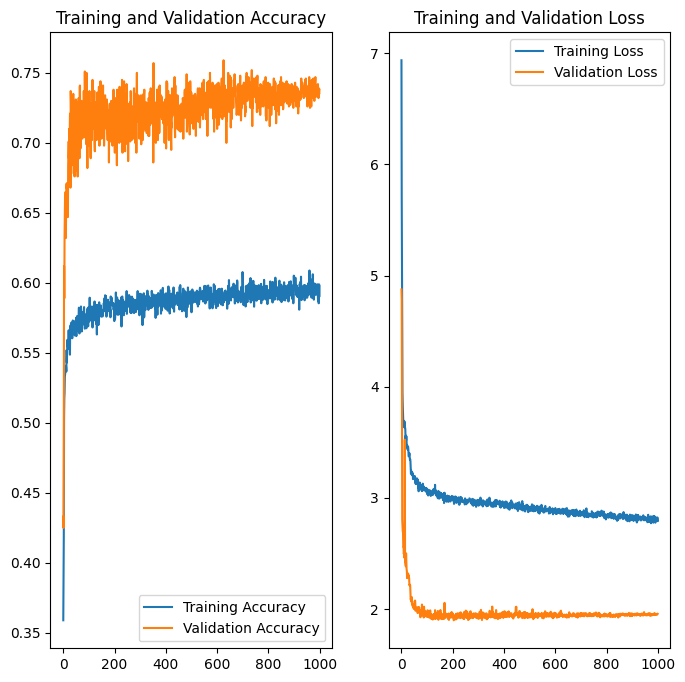

In [45]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

#epochs_range = range(val_epochs)
epochs_range = range(val_epochs)
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Guardamos los datos de Accuracy y Loss

In [46]:
df = pd.DataFrame.from_dict(history.history)
df.to_csv('../../../Gráficas finales/historycampvec100.csv', index=False)

# Guardamos el modelo

In [47]:
path_to_save = '../../../Modelos/Modelos 100,200'

In [48]:
model.save(path_to_save + '/campovectorial100.h5')

# Importamos el modelo

In [58]:
new_model = keras.models.load_model('../../../Modelos/Modelos 100,200/campovectorial100.h5', custom_objects={'custom_activation': custom_activation})

# Probamos el modelo con datos nuevos

## Creamos nuevos datos

In [109]:
import random
from scipy.integrate import solve_ivp

campvec = []
coef = []
contador = 0
for i in range(0, 1):
    # constantes
    a1 = random.randint(0, 10)
    a2 = random.randint(0, 10)
    b1 = random.randint(0, 10)
    b2 = random.randint(0, 10)
    d1 = random.randint(0, 10)
    d2 = random.randint(0, 10)
    n = random.randint(0, 5)

    coef1 = [a1, a2, b1, b2, d1, d2, n]
    coef.append(coef1)

    def f(t, y):

        # asignar a cada ODE a un elemento de vector
        X = y[0]
        Y = y[1]

        # definimos cada ODE
        # dX_dt=a1/(1+Y**n)-d1*X+b1
        # dY_dt=a2/(1+X**n)-d2*Y+b2
        dX_dt = a1/(1+Y**n)-d1*X+b1
        dY_dt = a2/(1+X**n)-d2*Y+b1

        return [dX_dt, dY_dt]

    x_range_neg = 0
    x_range_pos = 10
    y_range_neg = 0
    y_range_pos =10

    y1 = np.linspace(x_range_neg, x_range_pos, 100)
    y2 = np.linspace(y_range_neg, y_range_pos, 100)

    Y1, Y2 = np.meshgrid(y1, y2)
    
    t1 = 0

    u, v = np.zeros(Y1.shape), np.zeros(Y2.shape)

    NI, NJ = Y1.shape

    u1, v1 = f(t1, [Y1, Y2])
    u, v = f(t1, [Y1, Y2])
    M = (np.hypot(u, v))
    u /= M
    v /= M

    campvecci = np.append([u1], [v1], axis=0)

    campvec = campvecci
    print('--------------------------------------------')
    print(coef1)

    
campvec = np.array(campvec)
coef = np.array(coef)


--------------------------------------------
[7, 1, 5, 4, 10, 1, 1]


In [110]:
campvecnone = campvec[None, :]

## Predecimos con los datos nuevos

In [111]:
new_predictions = new_model.predict(campvecnone)
new_predictions = np.round(new_predictions)
new_predictions = np.clip(new_predictions, 0, None)
print(new_predictions)

1/1 [==============================] - 0s 17ms/step
[[ 7.  1.  5.  5. 10.  1.  1.]]


## Graficamos con los coeficientes reales

Text(0, 0.5, 'Concentración Y')

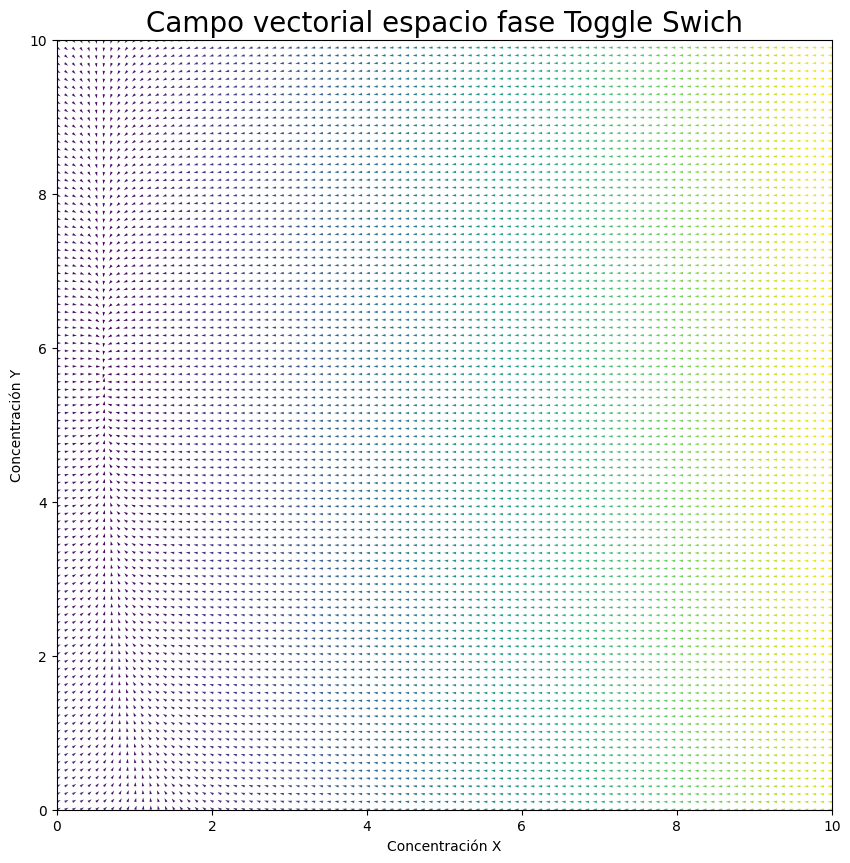

In [112]:
y1 = np.linspace(0, 10, 100)
y2 = np.linspace(0, 10, 100)
Y1, Y2 = np.meshgrid(y1, y2)
t1 = 0
u, v = np.zeros(Y1.shape), np.zeros(Y2.shape)
NI, NJ = Y1.shape        
u,v = np.array(campvec)[0,:,:], np.array(campvec)[1,:,:]
M = (np.hypot(u,v))
u /= M
v /= M

plt.figure(figsize=(10,10))
Q = plt.quiver(Y1, Y2, u, v, M, angles='xy')
plt.title('Campo vectorial espacio fase Toggle Swich', fontsize=20)
plt.xlim([0, 10])
plt.ylim([0, 10])
plt.xlabel('Concentración X')
plt.ylabel('Concentración Y')

## Graficamos con los coeficientes predecidos

Text(0, 0.5, 'Concentración Y')

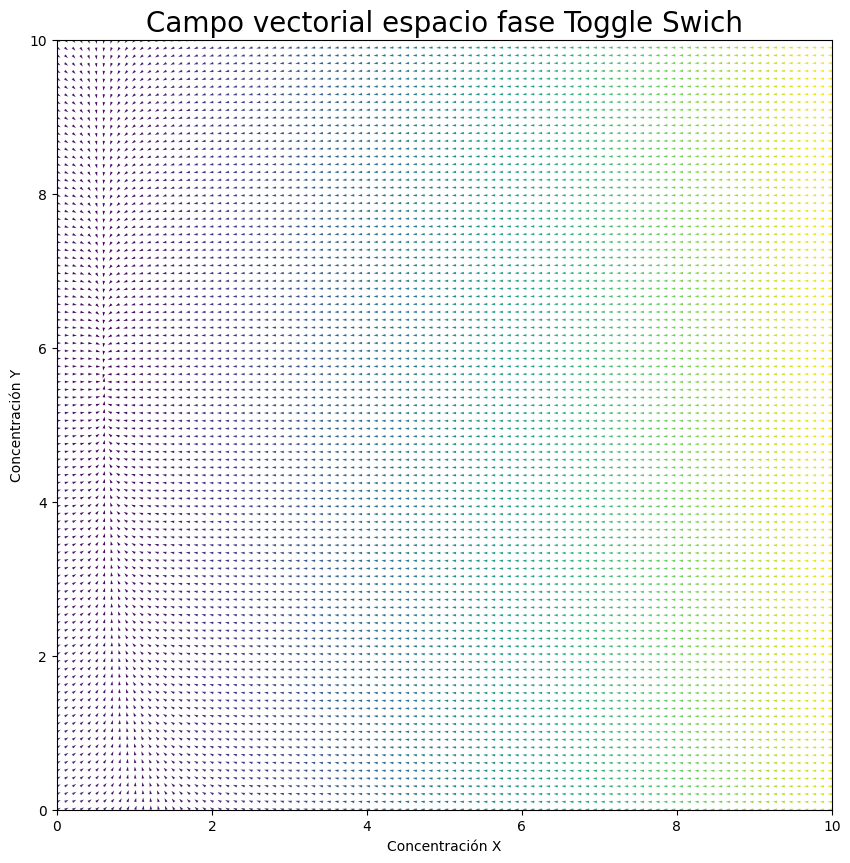

In [114]:
a1 = new_predictions[0,0]
a2 = new_predictions[0,1]
b1 = new_predictions[0,2]
b2 = new_predictions[0,3]
d1 = new_predictions[0,4]
d2 = new_predictions[0,5]
n = new_predictions[0,6]
def f(t, y):

    # asignar a cada ODE a un elemento de vector
    X = y[0]
    Y = y[1]

    # definimos cada ODE
    dX_dt = a1/(1+Y**n)-d1*X+b1
    dY_dt = a2/(1+X**n)-d2*Y+b1

    return [dX_dt, dY_dt]

x_range_neg = 0
x_range_pos = 10
y_range_neg = 0
y_range_pos = 10

y1pred = np.linspace(x_range_neg, x_range_pos, 100)
y2pred = np.linspace(y_range_neg, y_range_pos, 100)

Y1pred, Y2pred = np.meshgrid(y1pred, y2pred)
    
t1 = 0

upred, vpred = np.zeros(Y1pred.shape), np.zeros(Y2pred.shape)

NI, NJ = Y1.shape

u1pred, v1pred = f(t1, [Y1, Y2])
upred, vpred = f(t1, [Y1, Y2])
Mpred = (np.hypot(upred, vpred))
upred /= Mpred
vpred /= Mpred
    
plt.figure(figsize=(10, 10))
Q = plt.quiver(Y1, Y2, upred, vpred, Mpred, angles='xy')
plt.title('Campo vectorial espacio fase Toggle Swich', fontsize=20)
plt.xlim([x_range_neg, x_range_pos])
plt.ylim([y_range_neg, y_range_pos])
plt.xlabel('Concentración X')
plt.ylabel('Concentración Y')

## Graficamos ambos

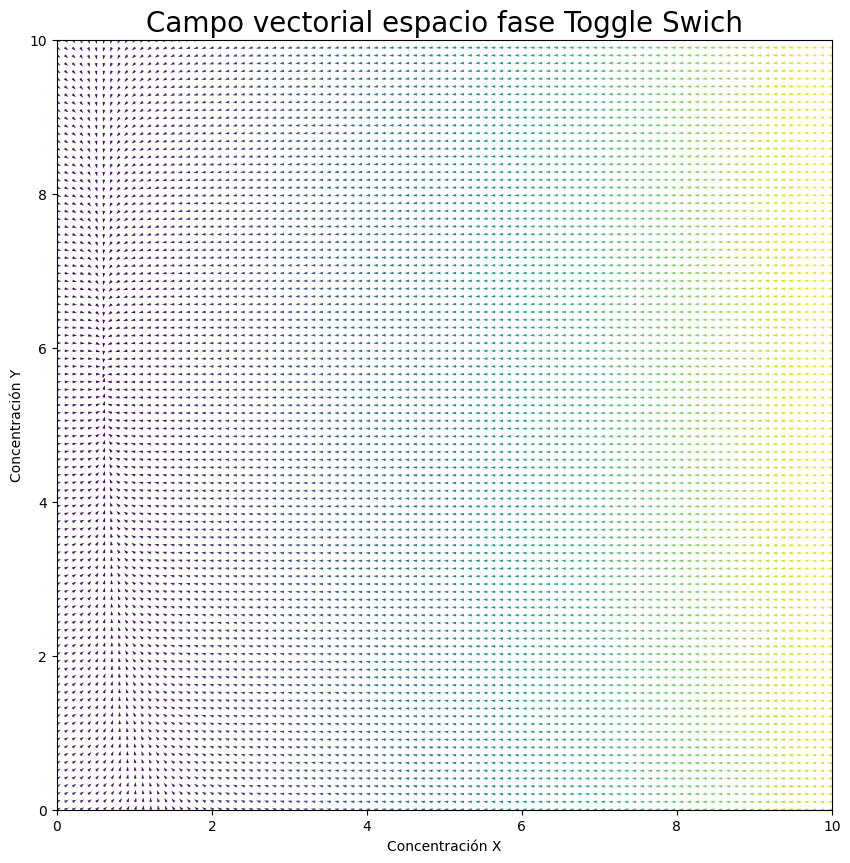

In [115]:
fig, ax = plt.subplots(figsize=(10, 10))

# Primero graficamos la predicción, que debería ser más clara (alpha < 1)
Q = ax.quiver(Y1, Y2, upred, vpred, Mpred, angles='xy', alpha=0.5)

# Luego, graficamos los datos originales, que serán más oscuros (alpha = 1)
Q1 = ax.quiver(Y1, Y2, u, v, M, angles='xy', alpha=1)

ax.set_title('Campo vectorial espacio fase Toggle Swich', fontsize=20)
ax.set_xlim([0, 10])
ax.set_ylim([0, 10])
ax.set_xlabel('Concentración X')
ax.set_ylabel('Concentración Y')

plt.show()

## Graficamos las diferencias

C:\Users\rafae\anaconda3\envs\tfcpu\lib\site-packages\matplotlib\quiver.py:646: RuntimeWarning: divide by zero encountered in double_scalars
  length = a * (widthu_per_lenu / (self.scale * self.width))
C:\Users\rafae\anaconda3\envs\tfcpu\lib\site-packages\matplotlib\quiver.py:646: RuntimeWarning: invalid value encountered in multiply
  length = a * (widthu_per_lenu / (self.scale * self.width))


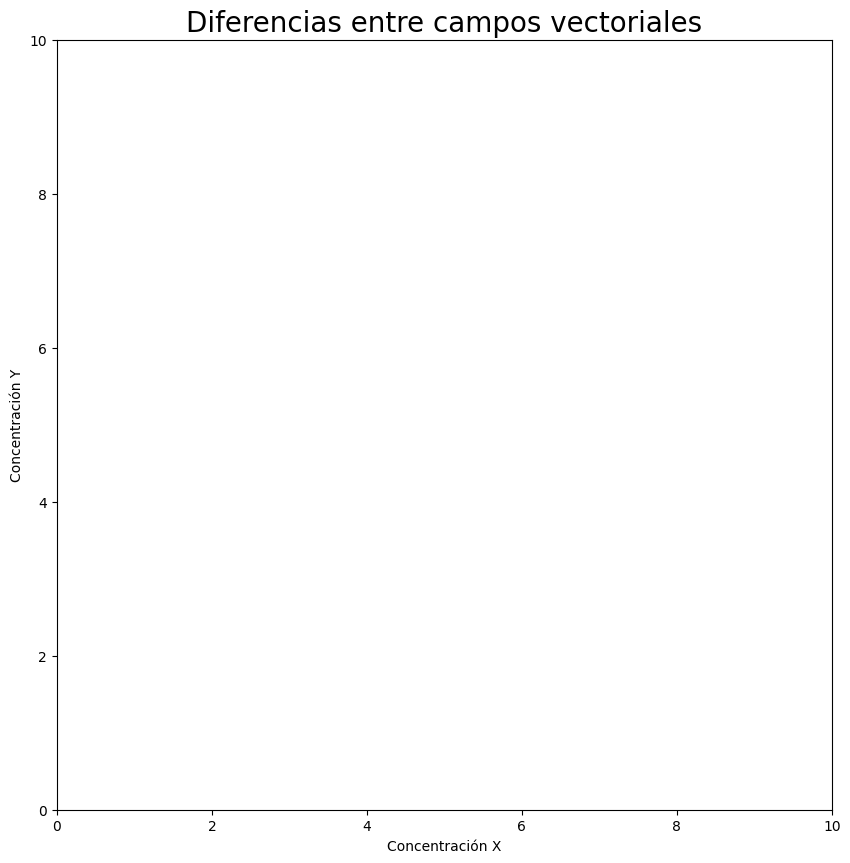

In [122]:
fig, ax = plt.subplots(figsize=(10, 10))

# Calculamos las diferencias
u_diff = u - upred
v_diff = v - vpred

# Aseguramos que ningún vector tenga una magnitud exactamente igual a cero
epsilon = 1e-7
u_diff2 = u_diff + epsilon
v_diff2 = v_diff + epsilon

# Ahora calculamos la magnitud
#M_diff = np.hypot(u_diff2, v_diff2)
M_diff = np.hypot(u_diff, v_diff)


# Graficamos las diferencias
#Q = ax.quiver(Y1, Y2, u_diff2, v_diff2, M_diff, angles='xy')
Q = ax.quiver(Y1, Y2, u_diff, v_diff, M_diff, angles='xy')


ax.set_title('Diferencias entre campos vectoriales', fontsize=20)
ax.set_xlim([0, 10])
ax.set_ylim([0, 10])
ax.set_xlabel('Concentración X')
ax.set_ylabel('Concentración Y')

plt.show()

In [123]:
M_diff.max()

0.0